# Analyse the Influence of Outliers

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Models & Normalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Hypothesis testing
from sklearn.model_selection import cross_val_score
from scipy import stats
import numpy as np


from utils import *



In [2]:
# Exporting plotly plots to pdf 
import plotly.io as pio

# Configuration: 

# Set to False for interactive zooming/hovering (Exploration)
# Set to True for static images (PDF Export)
EXPORT_MODE = True  

if EXPORT_MODE:
    # Forces all charts to be static images (requires 'pip install -U kaleido')
    pio.renderers.default = "png" # Use "png" if svg gives you trouble
    print("⚠️ EXPORT_MODE is ON. Charts will be static images.")
else:
    # Default interactive plotly
    pio.renderers.default = "notebook_connected"
    print("✅ Interactive mode. Charts will include zoom/hover.")

⚠️ EXPORT_MODE is ON. Charts will be static images.


## Open the clean data

In [3]:
file_path = "Data/v0_cleaned_house_sales.csv"

df_clean = pd.read_csv(file_path)
df_clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


## Analysing Prices

Text(0.5, 1.0, 'Histogram: price')

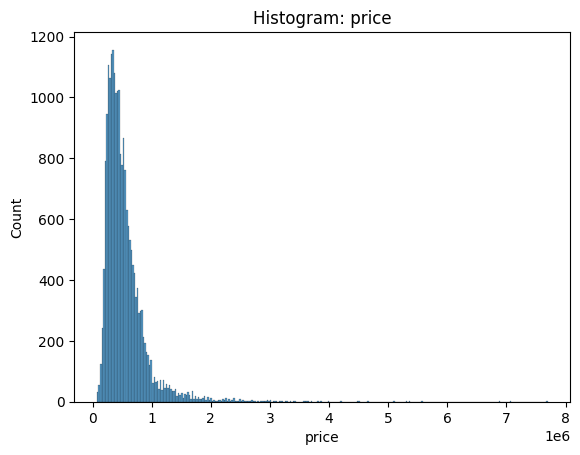

In [4]:
sns.histplot(df_clean.price)
plt.title("Histogram: price")

Text(0.5, 1.0, 'Boxplot: price')

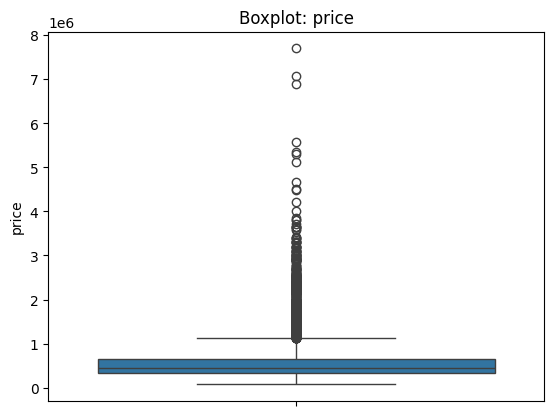

In [5]:
sns.boxplot(df_clean.price)
plt.title("Boxplot: price")

In [6]:
df_clean["price"].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [7]:
# 11 houses over 4 million
df_clean[df_clean.price > 4e6]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
1164,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,...,1999,0,98033,47.6767,-122.211,3430,26788,2014,10,20
1315,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,...,1991,0,98040,47.5631,-122.210,4320,24619,2015,4,13
1448,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,...,2009,0,98004,47.6232,-122.220,4600,21750,2015,4,13
2626,4500000.0,5,5.50,6640,40014,2.0,1,4,3,12,...,2004,0,98155,47.7493,-122.280,3030,23408,2014,8,15
3914,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,...,1940,2001,98004,47.6500,-122.214,3930,25449,2014,6,11
4411,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,...,2001,0,98039,47.6289,-122.233,3560,24345,2014,8,4
7252,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,...,1910,1987,98102,47.6298,-122.323,3940,8800,2014,10,13
8092,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,...,1983,2009,98040,47.5570,-122.210,3270,10454,2014,6,17
8638,4489000.0,4,3.00,6430,27517,2.0,0,0,3,12,...,2001,0,98004,47.6208,-122.219,3720,14592,2014,6,18
9254,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,...,2001,0,98039,47.6305,-122.240,4540,42730,2014,9,19


## How much of the data is represented by outliers? 

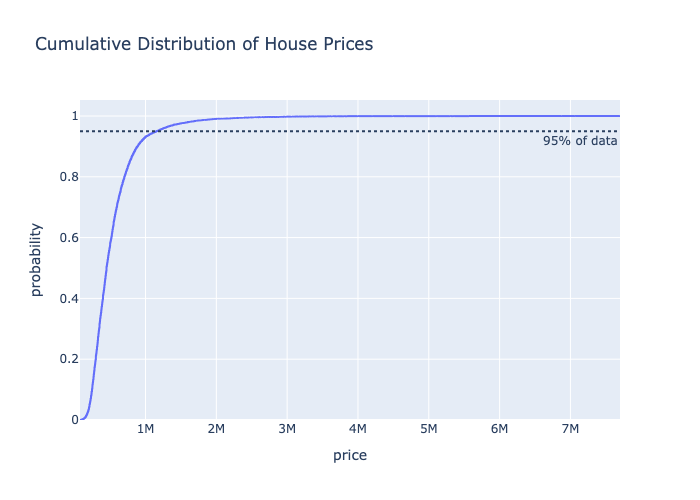

In [8]:
df_sorted = df_clean["price"].sort_values()

# Cumulative Quatiles
fig = px.ecdf(df_sorted, x="price", title="Cumulative Distribution of House Prices")

# Add a marker line at the 95th and 99th percentiles
fig.add_hline(y=0.95, line_dash="dot", annotation_text="95% of data", annotation_position="bottom right")
fig.show()


In [9]:
# quantiles
quantile_99 = df_clean.price.quantile(0.99)
quantile_95 = df_clean.price.quantile(0.95)

print("Quantile 99: ", quantile_99)
print("Quantile 95: ", quantile_95)


Quantile 99:  1964400.0000000051
Quantile 95:  1156479.9999999974


In [10]:
# Flag the datapoints inside each quantiles 99 and 95
df_clean["q_99"] = (df_clean.price < quantile_99).astype(int)
df_clean["q_95"] = (df_clean.price < quantile_95).astype(int)

df_clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,q_99,q_95
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,98178,47.5112,-122.257,1340,5650,2014,10,13,1,1
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,98125,47.7210,-122.319,1690,7639,2014,12,9,1,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,98028,47.7379,-122.233,2720,8062,2015,2,25,1,1
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,98136,47.5208,-122.393,1360,5000,2014,12,9,1,1
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,98074,47.6168,-122.045,1800,7503,2015,2,18,1,1


In [11]:
print(f"The 99th quantile exclude {df_clean.shape[0] - df_clean.q_99.sum()} datapoints")
print(f"The 95th quantile exclude {df_clean.shape[0] - df_clean.q_95.sum()} datapoints")

The 99th quantile exclude 217 datapoints
The 95th quantile exclude 1081 datapoints


## Sensitivity to outliers (metrics)

In [12]:
metrics_df = create_metrics_df()

### Random Forest flagging the outliers

In [13]:
# Split into train and test
seed = 13
# The price is the target variable
y = df_clean["price"]

# All other variables are the features for the baseline model
X = df_clean.drop(["price"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [14]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold,q_99,q_95
1571,4,1.50,2000,6778,1.0,0,0,4,7,1170,...,98198,47.3708,-122.311,1940,7531,2015,3,23,1,1
16330,4,2.50,2630,48706,2.0,0,0,3,8,2630,...,98072,47.7750,-122.125,2680,48706,2014,5,21,1,1
12786,4,2.50,2620,9525,2.5,0,0,4,9,2620,...,98040,47.5631,-122.219,2580,9525,2014,8,5,1,1
12524,3,2.50,1610,6000,2.0,0,0,4,7,1610,...,98038,47.3490,-122.036,1570,6000,2014,8,26,1,1
16179,3,1.00,880,18205,1.0,0,0,4,6,880,...,98178,47.5013,-122.244,1110,16115,2014,6,24,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,4,3.25,5180,19850,2.0,0,3,3,12,3540,...,98006,47.5620,-122.162,3160,9750,2015,4,1,0,0
866,3,2.50,3460,6590,2.0,0,0,3,7,3460,...,98056,47.4802,-122.188,2490,6312,2015,4,27,1,1
74,3,1.75,1790,50529,1.0,0,0,5,7,1090,...,98042,47.3511,-122.073,1940,50529,2015,3,16,1,1
14512,2,1.00,820,5040,1.0,0,0,3,7,820,...,98199,47.6498,-122.388,1730,5760,2014,8,20,1,1


In [15]:
# most common hyperparameters or the default ones

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)


metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Outliers flagging, no normalization.")

metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Outliers flagging, no normalization.")

In [16]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."


### Random Forest removing top 1% outliers

In [17]:
# Split into train and test
# The price is the target variable
y = df_clean[df_clean.q_99 == 1]["price"]

# All other variables are the features for the baseline model
X = df_clean[df_clean.q_99 == 1].drop(["price", "q_99", "q_95"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [18]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
16385,3,1.50,1290,8175,1.0,0,0,4,7,820,...,1952,0,98004,47.6296,-122.205,2130,8577,2014,8,20
16816,3,2.00,1830,10873,1.0,0,0,3,8,1830,...,1989,0,98023,47.3066,-122.394,2490,8976,2014,7,31
6038,3,1.75,1840,8086,1.0,0,0,4,8,1840,...,1964,0,98052,47.6700,-122.155,1840,8060,2014,6,23
16785,3,1.75,1540,10545,2.0,0,0,4,6,1540,...,1978,0,98045,47.4451,-121.763,1540,10000,2015,3,11
15744,3,2.00,2090,15790,1.0,0,0,3,9,2090,...,1992,0,98034,47.7296,-122.199,1820,8770,2014,11,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,3,1.00,1180,7669,1.0,0,0,4,7,1180,...,1967,0,98058,47.4479,-122.176,1190,7669,2014,7,28
878,3,1.00,1020,8100,1.0,0,0,3,7,1020,...,1954,0,98198,47.3586,-122.314,1020,8100,2014,12,19
75,4,4.00,3430,35102,2.0,0,0,4,10,2390,...,1986,0,98075,47.5822,-121.987,3240,35020,2014,11,5
14650,4,3.00,2530,5625,1.0,0,0,3,8,1470,...,1976,0,98034,47.7094,-122.233,1840,7070,2014,7,11


In [19]:
# most common hyperparameters or the default ones

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)


metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Removing top 1%, no normalization.")

metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Removing top 1%, no normalization.")

In [20]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."
2,RandomForestRegressor,train,0.9826,0.9826,23185.3777,0.0475,37273.0054,"Removing top 1%, no normalization."
3,RandomForestRegressor,test,0.8739,0.8733,64327.4972,0.1290,104088.2866,"Removing top 1%, no normalization."


### Random Forest removing top 5% outliers

In [21]:
# Split into train and test
# The price is the target variable
y = df_clean[df_clean.q_95 == 1]["price"]

# All other variables are the features for the baseline model
X = df_clean[df_clean.q_95 == 1].drop(["price", "q_99", "q_95"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [22]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
7523,3,1.00,1200,7810,1.0,0,0,4,7,1200,...,1967,0,98038,47.3631,-122.050,1590,7800,2015,4,25
20438,4,2.50,3250,4500,2.0,0,0,3,8,3250,...,2008,0,98059,47.4944,-122.150,3030,4598,2014,11,4
8571,4,2.50,2180,3893,2.0,0,0,3,8,2180,...,1999,0,98117,47.6886,-122.388,1710,4550,2014,12,8
15677,3,1.75,1990,5600,1.0,0,1,3,8,1330,...,1941,0,98199,47.6500,-122.415,2630,6780,2014,9,3
8032,3,1.75,2360,4063,1.0,0,0,5,7,1180,...,1940,0,98117,47.6902,-122.382,1660,4063,2014,8,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,4,1.75,1760,11180,1.0,0,0,4,8,1760,...,1968,0,98059,47.4715,-122.118,1730,11180,2014,10,3
907,3,1.75,1410,9315,1.0,0,0,5,7,1410,...,1960,0,98031,47.3969,-122.198,1630,8250,2014,10,7
78,3,1.00,1410,5060,1.0,0,0,4,7,910,...,1956,0,98133,47.7073,-122.340,1130,5693,2014,6,9
15224,4,2.50,2570,8178,1.0,0,2,3,8,1710,...,1961,0,98118,47.5483,-122.261,2050,7500,2015,3,9


In [23]:
# most common hyperparameters or the default ones

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)


metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Removing top 5%, no normalization.")

metrics_df = add_new_metrics(metrics_df,
                             rf_regressor,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Removing top 5%, no normalization.")

In [24]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."
2,RandomForestRegressor,train,0.9826,0.9826,23185.3777,0.0475,37273.0054,"Removing top 1%, no normalization."
3,RandomForestRegressor,test,0.8739,0.8733,64327.4972,0.1290,104088.2866,"Removing top 1%, no normalization."
4,RandomForestRegressor,train,0.9806,0.9806,19934.8930,0.0458,29386.2798,"Removing top 5%, no normalization."
5,RandomForestRegressor,test,0.8717,0.8710,53038.5069,0.1212,76308.9748,"Removing top 5%, no normalization."


### XGBoost flagging the outliers

In [25]:
# Split into train and test
seed = 13
# The price is the target variable
y = df_clean["price"]

# All other variables are the features for the baseline model
X = df_clean.drop(["price"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [26]:
xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [27]:
metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Outliers flagging, no normalization.")


metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Outliers flagging, no normalization.")

In [28]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."
2,RandomForestRegressor,train,0.9826,0.9826,23185.3777,0.0475,37273.0054,"Removing top 1%, no normalization."
3,RandomForestRegressor,test,0.8739,0.8733,64327.4972,0.1290,104088.2866,"Removing top 1%, no normalization."
4,RandomForestRegressor,train,0.9806,0.9806,19934.8930,0.0458,29386.2798,"Removing top 5%, no normalization."
5,RandomForestRegressor,test,0.8717,0.8710,53038.5069,0.1212,76308.9748,"Removing top 5%, no normalization."
6,XGBRegressor,train,0.9825,0.9825,35584.0027,0.0818,48751.1351,"Outliers flagging, no normalization."
7,XGBRegressor,test,0.9260,0.9256,59532.0485,0.1184,97798.9764,"Outliers flagging, no normalization."


### XGBoost removing top 1% 

In [29]:
# Split into train and test
# The price is the target variable
y = df_clean[df_clean.q_99 == 1]["price"]

# All other variables are the features for the baseline model
X = df_clean[df_clean.q_99 == 1].drop(["price", "q_99", "q_95"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [30]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
16385,3,1.50,1290,8175,1.0,0,0,4,7,820,...,1952,0,98004,47.6296,-122.205,2130,8577,2014,8,20
16816,3,2.00,1830,10873,1.0,0,0,3,8,1830,...,1989,0,98023,47.3066,-122.394,2490,8976,2014,7,31
6038,3,1.75,1840,8086,1.0,0,0,4,8,1840,...,1964,0,98052,47.6700,-122.155,1840,8060,2014,6,23
16785,3,1.75,1540,10545,2.0,0,0,4,6,1540,...,1978,0,98045,47.4451,-121.763,1540,10000,2015,3,11
15744,3,2.00,2090,15790,1.0,0,0,3,9,2090,...,1992,0,98034,47.7296,-122.199,1820,8770,2014,11,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,3,1.00,1180,7669,1.0,0,0,4,7,1180,...,1967,0,98058,47.4479,-122.176,1190,7669,2014,7,28
878,3,1.00,1020,8100,1.0,0,0,3,7,1020,...,1954,0,98198,47.3586,-122.314,1020,8100,2014,12,19
75,4,4.00,3430,35102,2.0,0,0,4,10,2390,...,1986,0,98075,47.5822,-121.987,3240,35020,2014,11,5
14650,4,3.00,2530,5625,1.0,0,0,3,8,1470,...,1976,0,98034,47.7094,-122.233,1840,7070,2014,7,11


In [31]:
xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [32]:
metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Removing top 1%, no normalization.")


metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Removing top 1%, no normalization.")

In [33]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."
2,RandomForestRegressor,train,0.9826,0.9826,23185.3777,0.0475,37273.0054,"Removing top 1%, no normalization."
3,RandomForestRegressor,test,0.8739,0.8733,64327.4972,0.1290,104088.2866,"Removing top 1%, no normalization."
4,RandomForestRegressor,train,0.9806,0.9806,19934.8930,0.0458,29386.2798,"Removing top 5%, no normalization."
5,RandomForestRegressor,test,0.8717,0.8710,53038.5069,0.1212,76308.9748,"Removing top 5%, no normalization."
6,XGBRegressor,train,0.9825,0.9825,35584.0027,0.0818,48751.1351,"Outliers flagging, no normalization."
7,XGBRegressor,test,0.9260,0.9256,59532.0485,0.1184,97798.9764,"Outliers flagging, no normalization."
8,XGBRegressor,train,0.9679,0.9679,36410.9174,0.0830,50584.7096,"Removing top 1%, no normalization."
9,XGBRegressor,test,0.8891,0.8885,61265.8381,0.1234,97618.3705,"Removing top 1%, no normalization."


### XGBoost removing top 5% 

In [34]:
# Split into train and test
# The price is the target variable
y = df_clean[df_clean.q_95 == 1]["price"]

# All other variables are the features for the baseline model
X = df_clean[df_clean.q_95 == 1].drop(["price", "q_99", "q_95"], axis=1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [35]:
xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [36]:
metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_train,
                             y_train,
                             split = "train",
                             comments="Removing top 5%, no normalization.")


metrics_df = add_new_metrics(metrics_df,
                             xgb_clf,
                             X_test,
                             y_test,
                             split = "test",
                             comments="Removing top 5%, no normalization.")

In [37]:
metrics_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,"Outliers flagging, no normalization."
1,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,"Outliers flagging, no normalization."
2,RandomForestRegressor,train,0.9826,0.9826,23185.3777,0.0475,37273.0054,"Removing top 1%, no normalization."
3,RandomForestRegressor,test,0.8739,0.8733,64327.4972,0.1290,104088.2866,"Removing top 1%, no normalization."
4,RandomForestRegressor,train,0.9806,0.9806,19934.8930,0.0458,29386.2798,"Removing top 5%, no normalization."
5,RandomForestRegressor,test,0.8717,0.8710,53038.5069,0.1212,76308.9748,"Removing top 5%, no normalization."
6,XGBRegressor,train,0.9825,0.9825,35584.0027,0.0818,48751.1351,"Outliers flagging, no normalization."
7,XGBRegressor,test,0.9260,0.9256,59532.0485,0.1184,97798.9764,"Outliers flagging, no normalization."
8,XGBRegressor,train,0.9679,0.9679,36410.9174,0.0830,50584.7096,"Removing top 1%, no normalization."
9,XGBRegressor,test,0.8891,0.8885,61265.8381,0.1234,97618.3705,"Removing top 1%, no normalization."


The feature flagging for both 99% and 95% worked better than removing the outliers, which means that the information about the top priced houses is still important
to accurately predict the prices. In that sense, we will continue the analysis using the flagging of the columns instead of dropping them.

# Data Leakage Analysis: Outlier Flagging

Our initial approach calculated outlier thresholds using the entire dataset, introducing data leakage by allowing test set information to influence training features. While this is common in exploratory phases, it risks inflating model performance. In this section, we apply hypothesis testing to determine if correcting this leakage results in a statistically significant difference in model predictions.

In [38]:
# Apply outlier flagging
def apply_flagging(X, y):
    # quantiles
    quantile_99 = y.quantile(0.99)
    quantile_95 = y.quantile(0.95)

    print("Quantile 99: ", quantile_99)
    print("Quantile 95: ", quantile_95)

    # Flag the datapoints inside each quantiles 99 and 95
    X["q_99"] = (y < quantile_99).astype(int)
    X["q_95"] = (y < quantile_95).astype(int)

    return X

## Preparing Datasets

In [39]:
# Split into train and test
seed = 13
# The price is the target variable
y = df_clean["price"]

# All other variables are the features for the baseline model
X = df_clean.drop(["price"], axis=1)

### Dataset without Leakage

In [40]:
# Data without leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Flagging
X_train = apply_flagging(X_train, y_train)
X_test = apply_flagging(X_test, y_test)

Quantile 99:  1980000.0
Quantile 95:  1150000.0
Quantile 99:  1945159.9999999944
Quantile 95:  1185000.0


### Dataset with Leakage

In [41]:
# Data with leakage

X_leakage = apply_flagging(X, y)

X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(X_leakage, y, test_size=0.2, random_state=seed)

Quantile 99:  1964400.0000000051
Quantile 95:  1156479.9999999974


### Experiment metrics df

In [42]:
# New metrics dataframe

leak_df = create_metrics_df()
leak_df

,Model,Split,R2,Adjusted_R2,MAE,RMSE,MAPE,Comments


## Statistical Significance Test: Random Forest Performance

### Without leakage 

In [43]:
# most common hyperparameters or the default ones

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)


leak_df = add_new_metrics(leak_df,
                             rf_regressor,
                             X_train,
                             y_train,
                             split = "train",
                             comments="No leakage.")

leak_df = add_new_metrics(leak_df,
                             rf_regressor,
                             X_test,
                             y_test,
                             split = "test",
                             comments="No leakage.")

leak_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9880,0.9879,22693.7463,0.0455,40491.8085,No leakage.
1,RandomForestRegressor,test,0.9331,0.9327,59616.8735,0.1197,92989.3473,No leakage.


### With leakage

In [44]:
# most common hyperparameters or the default ones

rf_regressor_leak = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor_leak.fit(X_train_leak, y_train_leak)


leak_df = add_new_metrics(leak_df,
                             rf_regressor_leak,
                             X_train_leak,
                             y_train_leak,
                             split = "train",
                             comments="with leakage.")

leak_df = add_new_metrics(leak_df,
                             rf_regressor_leak,
                             X_test_leak,
                             y_test_leak,
                             split = "test",
                             comments="with leakage.")

leak_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9880,0.9879,22693.7463,0.0455,40491.8085,No leakage.
1,RandomForestRegressor,test,0.9331,0.9327,59616.8735,0.1197,92989.3473,No leakage.
2,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,with leakage.
3,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,with leakage.


In [45]:
# Hypothesis testing for the test scores

# Ho: scores_leakage = scores_no_leakage 
# Ha: scores_leakage != scores_no_leakage  

# Method 1: With leakage
scores_leakage = cross_val_score(rf_regressor_leak, X_test_leak, y_test_leak, 
                                  cv=5, scoring='r2')

# Method 2: Without leakage  
scores_no_leakage = cross_val_score(rf_regressor, X_test, y_test,
                                     cv=5, scoring='r2')

# Paired t-test (same folds, so paired)
t_stat, p_value = stats.ttest_rel(scores_leakage, scores_no_leakage)

print(f"Mean R² with leakage: {scores_leakage.mean():.4f} ± {scores_leakage.std():.4f}")
print(f"Mean R² without leakage: {scores_no_leakage.mean():.4f} ± {scores_no_leakage.std():.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference is statistically significant. We reject the null hypothesis.")
else:
    print("Difference is NOT statistically significant. We cannot reject the null hypothesis.")


Mean R² with leakage: 0.9049 ± 0.0178
Mean R² without leakage: 0.9061 ± 0.0180
p-value: 0.1119
Difference is NOT statistically significant. We cannot reject the null hypothesis.


In [46]:
# Hypothesis testing for the train scores

# Ho: scores_leakage = scores_no_leakage 
# Ha: scores_leakage != scores_no_leakage  

# Method 1: With leakage
scores_leakage = cross_val_score(rf_regressor_leak, X_train_leak, y_train_leak, 
                                  cv=5, scoring='r2')

# Method 2: Without leakage  
scores_no_leakage = cross_val_score(rf_regressor, X_train, y_train,
                                     cv=5, scoring='r2')

# Paired t-test (same folds, so paired)
t_stat, p_value = stats.ttest_rel(scores_leakage, scores_no_leakage)

print(f"Mean R² with leakage: {scores_leakage.mean():.4f} ± {scores_leakage.std():.4f}")
print(f"Mean R² without leakage: {scores_no_leakage.mean():.4f} ± {scores_no_leakage.std():.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference is statistically significant. We reject the null hypothesis.")
else:
    print("Difference is NOT statistically significant. We cannot reject the null hypothesis.")


Mean R² with leakage: 0.9054 ± 0.0179
Mean R² without leakage: 0.9051 ± 0.0180
p-value: 0.6313
Difference is NOT statistically significant. We cannot reject the null hypothesis.


## Statistical Significance Test: XGBoost Performance

### No leakage

In [47]:
xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

leak_df = add_new_metrics(leak_df,
                             xgb_clf,
                             X_train,
                             y_train,
                             split = "train",
                             comments="No leakage.")

leak_df = add_new_metrics(leak_df,
                             xgb_clf,
                             X_test,
                             y_test,
                             split = "test",
                             comments="No leakage.")

leak_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9880,0.9879,22693.7463,0.0455,40491.8085,No leakage.
1,RandomForestRegressor,test,0.9331,0.9327,59616.8735,0.1197,92989.3473,No leakage.
2,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,with leakage.
3,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,with leakage.
4,XGBRegressor,train,0.9820,0.9820,35896.1715,0.0825,49457.6309,No leakage.
5,XGBRegressor,test,0.9240,0.9236,59986.6293,0.1188,99079.9228,No leakage.


In [48]:
xgb_clf_leak = xgb.XGBRegressor(seed = seed)
xgb_clf_leak.fit(X_train_leak, y_train_leak)

leak_df = add_new_metrics(leak_df,
                             xgb_clf_leak,
                             X_train_leak,
                             y_train_leak,
                             split = "train",
                             comments="with leakage.")

leak_df = add_new_metrics(leak_df,
                             xgb_clf_leak,
                             X_test_leak,
                             y_test_leak,
                             split = "test",
                             comments="with leakage.")

leak_df

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,RandomForestRegressor,train,0.9880,0.9879,22693.7463,0.0455,40491.8085,No leakage.
1,RandomForestRegressor,test,0.9331,0.9327,59616.8735,0.1197,92989.3473,No leakage.
2,RandomForestRegressor,train,0.9879,0.9879,22769.7215,0.0456,40566.2303,with leakage.
3,RandomForestRegressor,test,0.9322,0.9319,59863.8409,0.1203,93599.4998,with leakage.
4,XGBRegressor,train,0.9820,0.9820,35896.1715,0.0825,49457.6309,No leakage.
5,XGBRegressor,test,0.9240,0.9236,59986.6293,0.1188,99079.9228,No leakage.
6,XGBRegressor,train,0.9825,0.9825,35584.0027,0.0818,48751.1351,with leakage.
7,XGBRegressor,test,0.9260,0.9256,59532.0485,0.1184,97798.9764,with leakage.


In [49]:
# Hypothesis testing for the test scores

# Ho: scores_leakage = scores_no_leakage 
# Ha: scores_leakage != scores_no_leakage  

# Method 1: With leakage
scores_leakage = cross_val_score(xgb_clf_leak, X_test_leak, y_test_leak, 
                                  cv=5, scoring='r2')

# Method 2: Without leakage  
scores_no_leakage = cross_val_score(xgb_clf, X_test, y_test,
                                     cv=5, scoring='r2')

# Paired t-test (same folds, so paired)
t_stat, p_value = stats.ttest_rel(scores_leakage, scores_no_leakage)

print(f"Mean R² with leakage: {scores_leakage.mean():.4f} ± {scores_leakage.std():.4f}")
print(f"Mean R² without leakage: {scores_no_leakage.mean():.4f} ± {scores_no_leakage.std():.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference is statistically significant. We reject the null hypothesis.")
else:
    print("Difference is NOT statistically significant. We cannot reject the null hypothesis.")


Mean R² with leakage: 0.9073 ± 0.0139
Mean R² without leakage: 0.9064 ± 0.0166
p-value: 0.6127
Difference is NOT statistically significant. We cannot reject the null hypothesis.


In [50]:
# Hypothesis testing for the train scores

# Ho: scores_leakage = scores_no_leakage 
# Ha: scores_leakage != scores_no_leakage  

# Method 1: With leakage
scores_leakage = cross_val_score(xgb_clf_leak, X_train_leak, y_train_leak, 
                                  cv=5, scoring='r2')

# Method 2: Without leakage  
scores_no_leakage = cross_val_score(xgb_clf, X_train, y_train,
                                     cv=5, scoring='r2')

# Paired t-test (same folds, so paired)
t_stat, p_value = stats.ttest_rel(scores_leakage, scores_no_leakage)

print(f"Mean R² with leakage: {scores_leakage.mean():.4f} ± {scores_leakage.std():.4f}")
print(f"Mean R² without leakage: {scores_no_leakage.mean():.4f} ± {scores_no_leakage.std():.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference is statistically significant. We reject the null hypothesis.")
else:
    print("Difference is NOT statistically significant. We cannot reject the null hypothesis.")


Mean R² with leakage: 0.9063 ± 0.0137
Mean R² without leakage: 0.9095 ± 0.0149
p-value: 0.5156
Difference is NOT statistically significant. We cannot reject the null hypothesis.


## Conclusion on Leakage

Statistical testing showed no significant difference between the approaches. For the scope of this analysis, we will proceed with the current implementation for simplicity, while acknowledging that a production-grade deployment would require the leakage-free pipeline to ensure strict data isolation.

## Export Dataset and Metrics

In [51]:
# filename_metrics = "Metrics/outlier_analysis_metrics.csv"

# metrics_df.to_csv(filename_metrics, index = False)

In [52]:
# df_clean

In [53]:
# filename_data = "Data/v1_house_sales.csv"

# df_clean.to_csv(filename_data, index = False)